<a href="https://colab.research.google.com/github/johnpharmd/DS-Unit-1-Sprint-4-Statistical-Tests-and-Experiments/blob/master/DS_Unit_1_Sprint_Challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Unit 1 Sprint Challenge 4

## Exploring Data, Testing Hypotheses

In this sprint challenge you will look at a dataset of people being approved or rejected for credit.

https://archive.ics.uci.edu/ml/datasets/Credit+Approval

Data Set Information: This file concerns credit card applications. All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data. This dataset is interesting because there is a good mix of attributes -- continuous, nominal with small numbers of values, and nominal with larger numbers of values. There are also a few missing values.

Attribute Information:
- A1: b, a.
- A2: continuous.
- A3: continuous.
- A4: u, y, l, t.
- A5: g, p, gg.
- A6: c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff.
- A7: v, h, bb, j, n, z, dd, ff, o.
- A8: continuous.
- A9: t, f.
- A10: t, f.
- A11: continuous.
- A12: t, f.
- A13: g, p, s.
- A14: continuous.
- A15: continuous.
- A16: +,- (class attribute)

Yes, most of that doesn't mean anything. A16 (the class attribute) is the most interesting, as it separates the 307 approved cases from the 383 rejected cases. The remaining variables have been obfuscated for privacy - a challenge you may have to deal with in your data science career.

Sprint challenges are evaluated based on satisfactory completion of each part. It is suggested you work through it in order, getting each aspect reasonably working, before trying to deeply explore, iterate, or refine any given step. Once you get to the end, if you want to go back and improve things, go for it!

## Part 1 - Load and validate the data

- Load the data as a `pandas` data frame.
- Validate that it has the appropriate number of observations (you can check the raw file, and also read the dataset description from UCI).
- UCI says there should be missing data - check, and if necessary change the data so pandas recognizes it as na
- Make sure that the loaded features are of the types described above (continuous values should be treated as float), and correct as necessary

This is review, but skills that you'll use at the start of any data exploration. Further, you may have to do some investigation to figure out which file to load from - that is part of the puzzle.

In [0]:
import pandas as pd
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data

--2018-12-07 16:05:57--  https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32218 (31K) [text/plain]
Saving to: ‘crx.data’

crx.data            100%[===================>]  31.46K  --.-KB/s    in 0.1s    

2018-12-07 16:05:57 (237 KB/s) - ‘crx.data’ saved [32218/32218]



In [0]:
# Notes on columns
# A8, A9, A11 appear to be True/False
# A15 is whether person was approved or not for credit
col_names = [i for i in range(1, 17)]  # use when ready to rename columns

df = pd.read_csv('crx.data', header=None, names=col_names)
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [0]:
df.shape

(690, 16)

In [0]:
for col in (11, 15):
  df[col] = df[col].astype(float)

df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1.0,f,g,00202,0.0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6.0,f,g,00043,560.0,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0.0,f,g,00280,824.0,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5.0,t,g,00100,3.0,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0.0,f,s,00120,0.0,+


In [0]:
df[14] = pd.to_numeric(df[14], errors='coerce')

count     677.000000
mean      184.014771
std       173.806768
min         0.000000
25%        75.000000
50%       160.000000
75%       276.000000
max      2000.000000
Name: 14, dtype: float64

In [0]:
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1.0,f,g,202.0,0.0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6.0,f,g,43.0,560.0,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0.0,f,g,280.0,824.0,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5.0,t,g,100.0,3.0,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0.0,f,s,120.0,0.0,+


In [0]:
df[df[14].isna()]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
71,b,34.83,4.000,u,g,d,bb,12.500,t,f,0.0,t,g,NaN,0.0,-
202,b,24.83,2.750,u,g,c,v,2.250,t,t,6.0,f,g,NaN,600.0,+
206,a,71.58,0.000,?,?,?,?,0.000,f,f,0.0,f,p,NaN,0.0,+
243,a,18.75,7.500,u,g,q,v,2.710,t,t,5.0,f,g,NaN,26726.0,+
270,b,37.58,0.000,?,?,?,?,0.000,f,f,0.0,f,p,NaN,0.0,+
278,b,24.58,13.500,y,p,ff,ff,0.000,f,f,0.0,f,g,NaN,0.0,-
330,b,20.42,0.000,?,?,?,?,0.000,f,f,0.0,f,p,NaN,0.0,-
406,a,40.33,8.125,y,p,k,v,0.165,f,t,2.0,f,g,NaN,18.0,-
445,a,?,11.250,u,g,ff,ff,0.000,f,f,0.0,f,g,NaN,5200.0,-
456,b,34.58,0.000,?,?,?,?,0.000,f,f,0.0,f,p,NaN,0.0,-


In [0]:
import numpy as np
df.replace('?', np.nan, inplace=True)
df.isin(['?']).sum()

1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
dtype: int64

In [0]:
df.isin([np.nan]).sum()

1     12
2     12
3      0
4      6
5      6
6      9
7      9
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
dtype: int64

In [0]:
df[df[14].isna()]
df.replace('NaN', np.nan, inplace=True)
df.isna().sum()

1     12
2     12
3      0
4      6
5      6
6      9
7      9
8      0
9      0
10     0
11     0
12     0
13     0
14    13
15     0
16     0
dtype: int64

In [0]:
# Change '-' to 0, '+' to 1
df.replace({'-': 0, '+': 1}, inplace=True)
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1.0,f,g,202.0,0.0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6.0,f,g,43.0,560.0,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0.0,f,g,280.0,824.0,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5.0,t,g,100.0,3.0,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0.0,f,s,120.0,0.0,1


## Part 2 - Exploring data, Testing hypotheses

The only thing we really know about this data is that A16 is the class label. Besides that, we have 6 continuous (float) features and 9 categorical features.

Explore the data: you can use whatever approach (tables, utility functions, visualizations) to get an impression of the distributions and relationships of the variables. In general, your goal is to understand how the features are different when grouped by the two class labels (`+` and `-`).

For the 6 continuous features, how are they different when split between the two class labels? Choose two features to run t-tests (again split by class label) - specifically, select one feature that is *extremely* different between the classes, and another feature that is notably less different (though perhaps still "statistically significantly" different). You may have to explore more than two features to do this.

For the categorical features, explore by creating "cross tabs" between them and the class label, and apply the Chi-squared test to them. There are 9 categorical features - as with the t-test, try to find one where the Chi-squared test returns an extreme result (rejecting the null that the data are independent), and one where it is less extreme.

**NOTE** - "less extreme" just means smaller test statistic/larger p-value. Even the least extreme differences may be strongly statistically significant.

Your *main* goal is the hypothesis tests, so don't spend too much time on the exploration/visualization piece. That is just a means to an end. This is challenging, so manage your time and aim for a baseline of at least running two t-tests and two Chi-squared tests before polishing. And don't forget to answer the questions in part 3, even if your results in this part aren't what you want them to be.

In [0]:
# Group data by A16
group_by_approval = df.groupby(df[16])
for tup in group_by_approval:  # first tuple is group of those approved, second those not approved
  print(tup)

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize groupby object
group_by_approval.plot.hist()  # A15 seems to be highly associated with A16
# ?sns.pairplot(data=df, hue=df[15])

In [0]:
# Look more at A16, the class label, with ttest_1samp
from scipy import stats

stats.ttest_1samp(df[16], 0.5)  # h_sub_zero that equal number got approved as not approved

# Ttest_1sampResult(statistic=-2.9088721445109043, pvalue=0.0037441556293534564)
# Interp:
# Reject h_sub_zero: there is a statistically significant diffence between
# number approved (307) and number not approved (383)

In [0]:
# Look now at A15 with ttest_1samp
# df[15].describe()  # guess here is that this is total amount of USD in savings
# df[15].mean()  # == 1017.3855072463768

h_sub_zero_avg_savings = 100000 * (307/690)
stats.ttest_1samp(df[15], h_sub_zero_avg_savings)  # h_sub_zero that those who were approved had this amount of savings
# Ttest_1sampResult(statistic=-219.19040431007832, pvalue=0.0)
# Interp:
# Reject h_sub_zero: look at that t-statistic! There is a statistically
# significant difference between null hypothesized savings and actual savings of those approved

In [0]:
# Compare (in)dependence of A16 on A15, using chisquare
# Make crosstab of df[15], df[16]
savings_approval_ctab = pd.crosstab(df[15], df[16])
# savings_approval_ctab
stats.chisquare(savings_approval_ctab)  # h_sub_zero here that approval is not dependent on savings on-hand
# Power_divergenceResult(statistic=array([21116.11227154,  9984.85667752]), pvalue=array([0., 0.]))
# Interp:
# Reject h_sub_zero: p-values are both near 0. Approval is very much dependent on having
# an integer >1000 as individual value for A15.

Power_divergenceResult(statistic=array([21116.11227154,  9984.85667752]), pvalue=array([0., 0.]))

In [0]:
# Compare (in)dependence of A16 on A6, using chisquare. A6 looks like some kind of categorical rating/score
# df[6].value_counts()
# Make crosstab of df[6], df[16]
a6_a16_ctab = pd.crosstab(df[6], df[16])
# a6_a16_ctab
stats.chisquare(a6_a16_ctab)  #h_sub_zero here that all categories equally likely to be approved
# Power_divergenceResult(statistic=array([192.88888889, 192.08250825]), pvalue=array([3.92856583e-34, 5.74696418e-34]))
# Interp:
# Reject h_sub_zero: p-values are highly significant. It's clear from this test that approvals were more likely
# depending on one's category here.

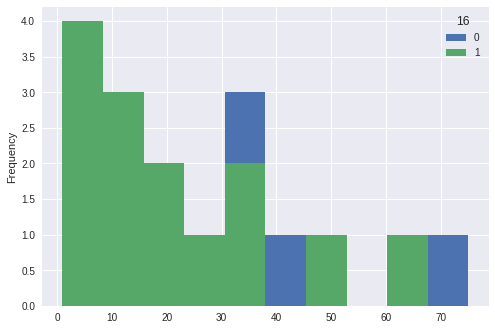

In [111]:
# Plot histogram of a6_a16_ctab  # recall that 0 is not-approved, 1 is approved
a6_a16_ctab.plot.hist();

## Part 3 - Analysis and Interpretation

Now that you've looked at the data, answer the following questions:

- Interpret and explain the two t-tests you ran - what do they tell you about the relationships between the continuous features you selected and the class labels?
- Interpret and explain the two Chi-squared tests you ran - what do they tell you about the relationships between the categorical features you selected and the class labels?
- What was the most challenging part of this sprint challenge?

Answer with text, but feel free to intersperse example code/results or refer to it from earlier.

First t-test:

### Look more at A16, the class label, with ttest_1samp
Code:

stats.ttest_1samp(df[16], 0.5)  # h_sub_zero that equal number got approved as not approved
Ttest_1sampResult(statistic=-2.9088721445109043, pvalue=0.0037441556293534564)

#### Interpretation:
Reject h_sub_zero: there is a statistically significant diffence between number approved (307) and number not approved (383)

Second t-test:
### Look now at A15 with ttest_1samp
Code:

df[15].describe()  # guess here is that this is total amount of USD in savings
df[15].mean()  # == 1017.3855072463768

h_sub_zero_avg_savings = 100000 * (307/690)
stats.ttest_1samp(df[15], h_sub_zero_avg_savings)  # h_sub_zero that those who were approved had this amount of savings
Ttest_1sampResult(statistic=-219.19040431007832, pvalue=0.0)
#### Interpretation:
Reject h_sub_zero: look at that t-statistic! There is a statistically significant difference between null hypothesized savings and actual savings of those approved.

---

### For chisquare test explanations and interpretations, please see chisquare code blocks in Part 2.

---
### Answer to the question...
Q: "What was the most challenging part of this sprint challenge?"

A: I thought Part 1 was slightly more difficult than Part 2. But I enjoyed the entire SC.
